In [1]:
cd ..

/home/janek/mag/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from src.reasoner_mod import *
from src.generate import load_dataset, split_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *


In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32
#FIRST PHASE

In [4]:
T.manual_seed(seed)
reasoner_original = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders_original = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]
print(f'created reasoner with {paramcount(reasoner_original)} parameters')
print(f'created {len(encoders_original)} encoders with {paramcount(encoders_original[0])} parameters each')

T.manual_seed(seed)
reasoner_mod = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders_mod = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]
print(f'created reasoner with {paramcount(reasoner_mod)} parameters')
print(f'created {len(encoders_mod)} encoders with {paramcount(encoders_mod[0])} parameters each')

train_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('original reasoner', reasoner_original), ('modified reasoner', reasoner_mod)]:
    print(reasoner_name)
    T.manual_seed(seed)
    random.seed(seed)
    if reasoner_name == 'original reasoner':
        train(data_tr, data_vl, reasoner, encoders_original, epoch_count=epoch_count, batch_size=batch_size, run_name=reasoner_name, logger=train_logger)
    else:
        train_mod(data_tr, data_vl, reasoner, encoders_mod, epoch_count=epoch_count, batch_size=batch_size, run_name=reasoner_name, logger=train_logger, identities_weight=0.028, identitity_weight_decay=0.96)


created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each
created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
original reasoner
train epoch 00/15 | batch 2001/2000 | loss 0.7203 | val loss 0.7208 | acc 0.2127 | f1 0.3507 | prec 0.2127 | recall 0.9977 | roc auc 0.5263 | pr auc 0.2339 | elapsed 20.43s
train epoch 01/15 | batch 2001/2000 | loss 0.5711 | val loss 0.4892 | acc 0.8069 | f1 0.1765 | prec 0.9707 | recall 0.0971 | roc auc 0.6465 | pr auc 0.4157 | elapsed 64.35s
train epoch 02/15 | batch 2001/2000 | loss 0.4404 | val loss 0.3973 | acc 0.8330 | f1 0.4320 | prec 0.7852 | recall 0.2979 | roc auc 0.8112 | pr auc 0.6426 | elapsed 66.19s
train epoch 03/15 | batch 2001/2000 | loss 0.3353 | val loss 0.3242 | acc 0.8804 | f1 0.6502 | prec 0.8628 | recall 0.5217 | roc auc 0.8652 | pr auc 0.7659 | elapsed 60.51s
train epoch 04/15 | batch 2001/2000 | loss 0.2613 | val loss 0.2790 | acc 0.9096 | f1 0.7487 | prec 0.9182 | recall 0.6320

In [5]:
## --- SECOND PHASE
trained_test_encoders = {}
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('original reasoner', reasoner_original), ('modified reasoner', reasoner_mod)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'original reasoner':
        train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)
    else:
        train_mod(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)


original reasoner


train epoch 00/10 | batch 1251/1250 | loss 1.3788 | val loss 1.3788 | acc 0.5880 | f1 0.4043 | prec 0.2948 | recall 0.6431 | roc auc 0.6731 | pr auc 0.4912 | elapsed 15.38s
train epoch 01/10 | batch 1251/1250 | loss 1.1203 | val loss 0.8483 | acc 0.6983 | f1 0.4871 | prec 0.3863 | recall 0.6592 | roc auc 0.7554 | pr auc 0.5823 | elapsed 33.18s
train epoch 02/10 | batch 1251/1250 | loss 0.6914 | val loss 0.5235 | acc 0.8002 | f1 0.5998 | prec 0.5312 | recall 0.6888 | roc auc 0.8319 | pr auc 0.6935 | elapsed 33.04s
train epoch 03/10 | batch 1251/1250 | loss 0.4424 | val loss 0.3478 | acc 0.8682 | f1 0.7035 | prec 0.6885 | recall 0.7192 | roc auc 0.8873 | pr auc 0.7953 | elapsed 33.43s
train epoch 04/10 | batch 1251/1250 | loss 0.3104 | val loss 0.2566 | acc 0.9082 | f1 0.7783 | prec 0.8187 | recall 0.7417 | roc auc 0.9221 | pr auc 0.8614 | elapsed 32.74s
train epoch 05/10 | batch 1251/1250 | loss 0.2401 | val loss 0.2056 | acc 0.9288 | f1 0.8234 | prec 0.8940 | recall 0.7632 | roc auc 0.

In [6]:
with T.no_grad():
    idx_te, X_te, y_te = data_te
    _, _, Y_te_orig = eval_batch(reasoner_original, trained_test_encoders['original reasoner'], X_te, y_te, idx_te)
    _, _, Y_te_mod = eval_batch(reasoner_mod, trained_test_encoders['modified reasoner'], X_te, y_te, idx_te)

local/out/exp/20240808T145442


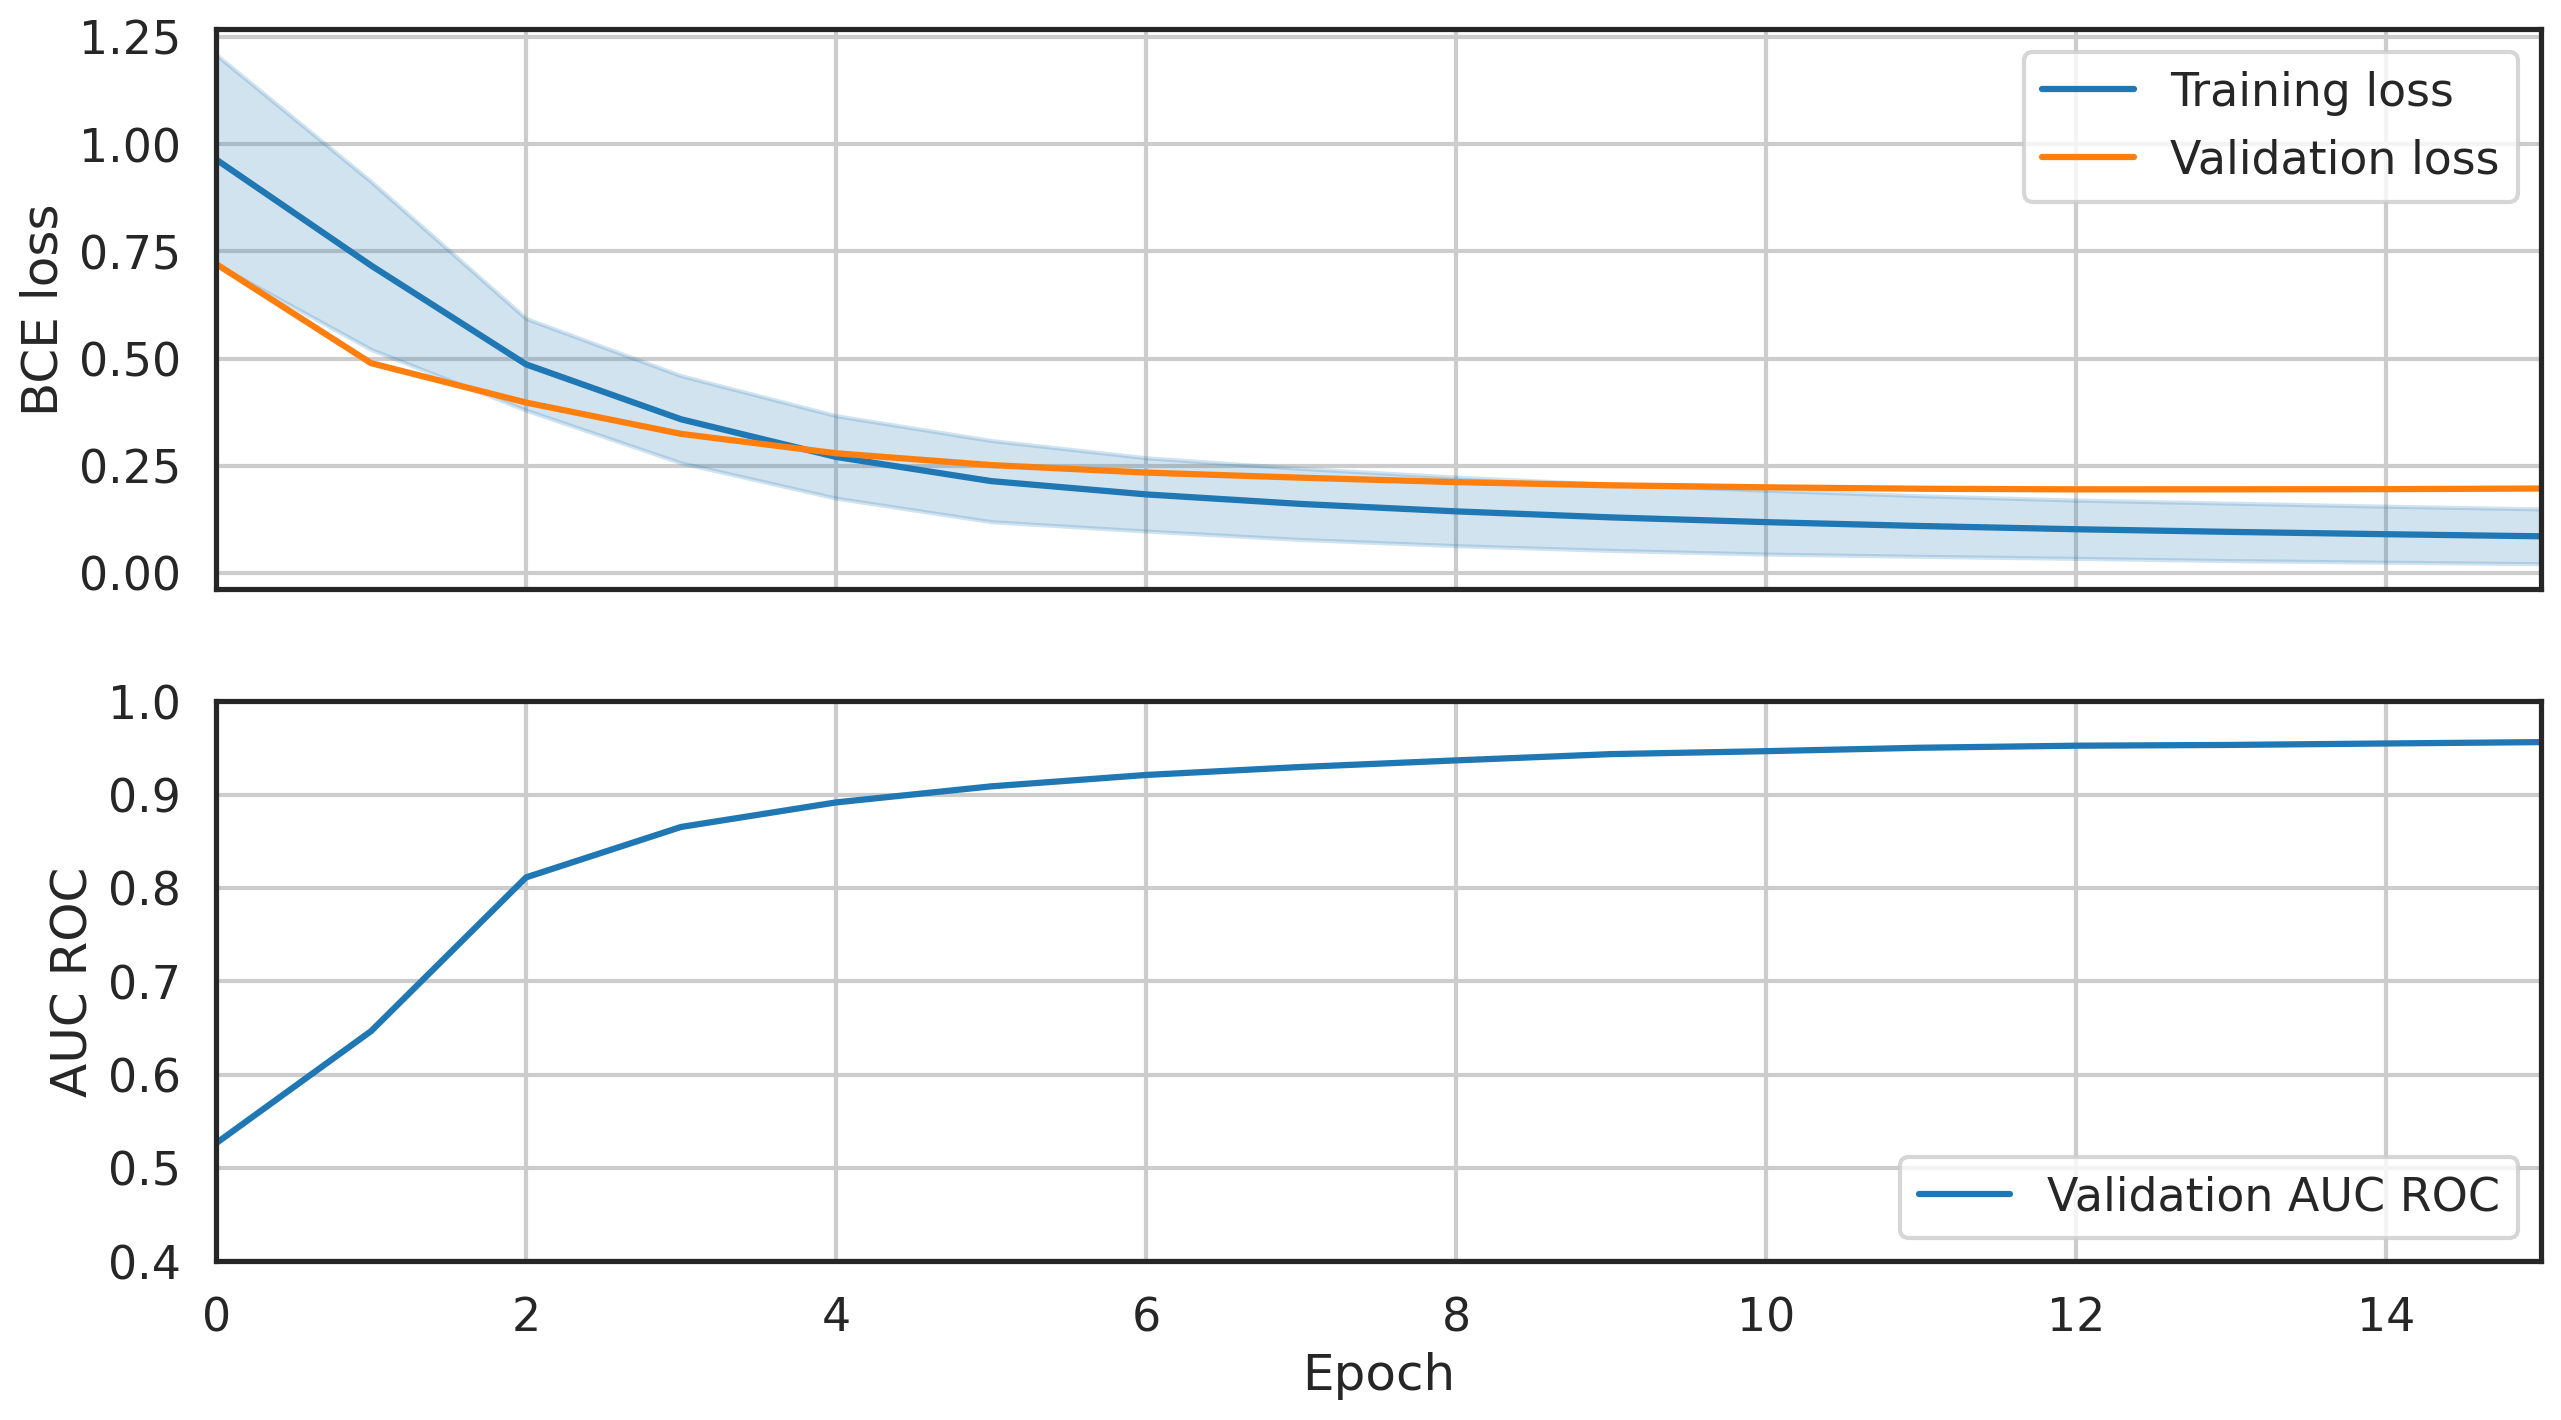

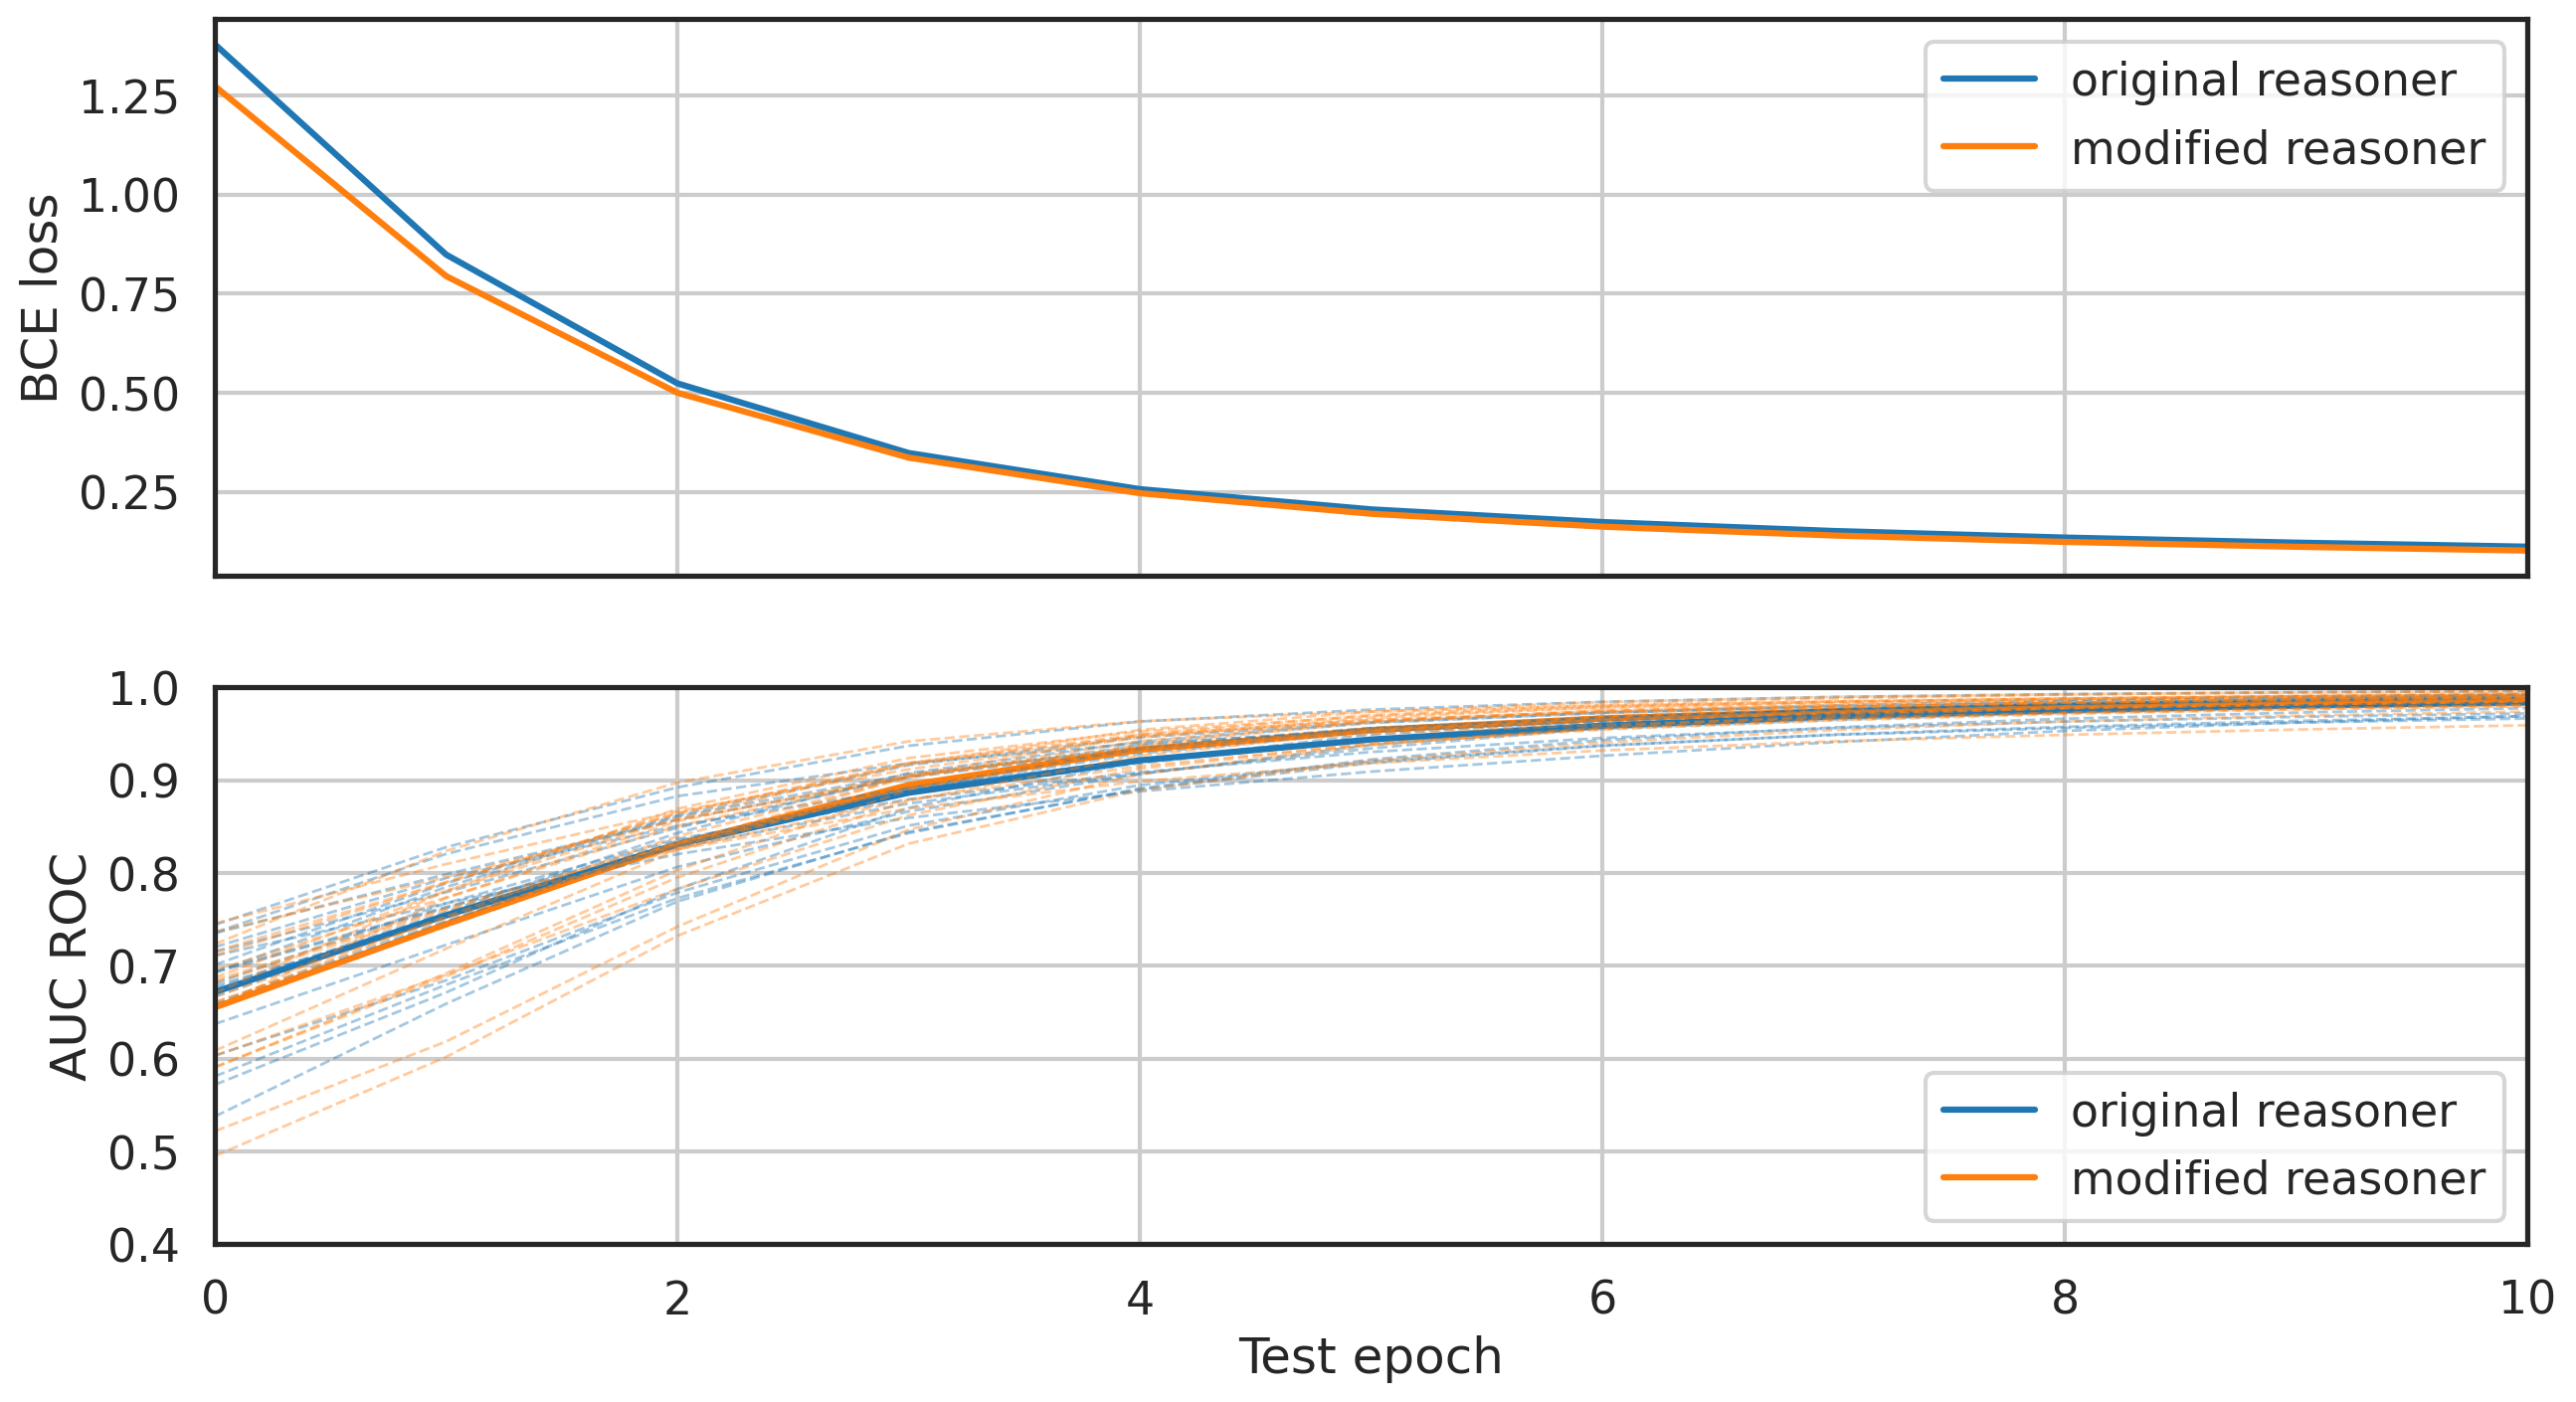

original
             mean       std     micro
acc      0.960850  0.014991  0.960850
prec     0.967708  0.025768  0.967725
recall   0.847299  0.044285  0.848206
f1       0.903242  0.034799  0.904032
auc_roc  0.983730  0.008664  0.984813
auc_pr   0.964303  0.018246  0.966525
modified
             mean       std     micro
acc      0.964225  0.015578  0.964225
prec     0.961018  0.029104  0.961036
recall   0.869031  0.047635  0.870745
f1       0.912402  0.037473  0.913665
auc_roc  0.986189  0.008535  0.987290
auc_pr   0.968190  0.018218  0.970894


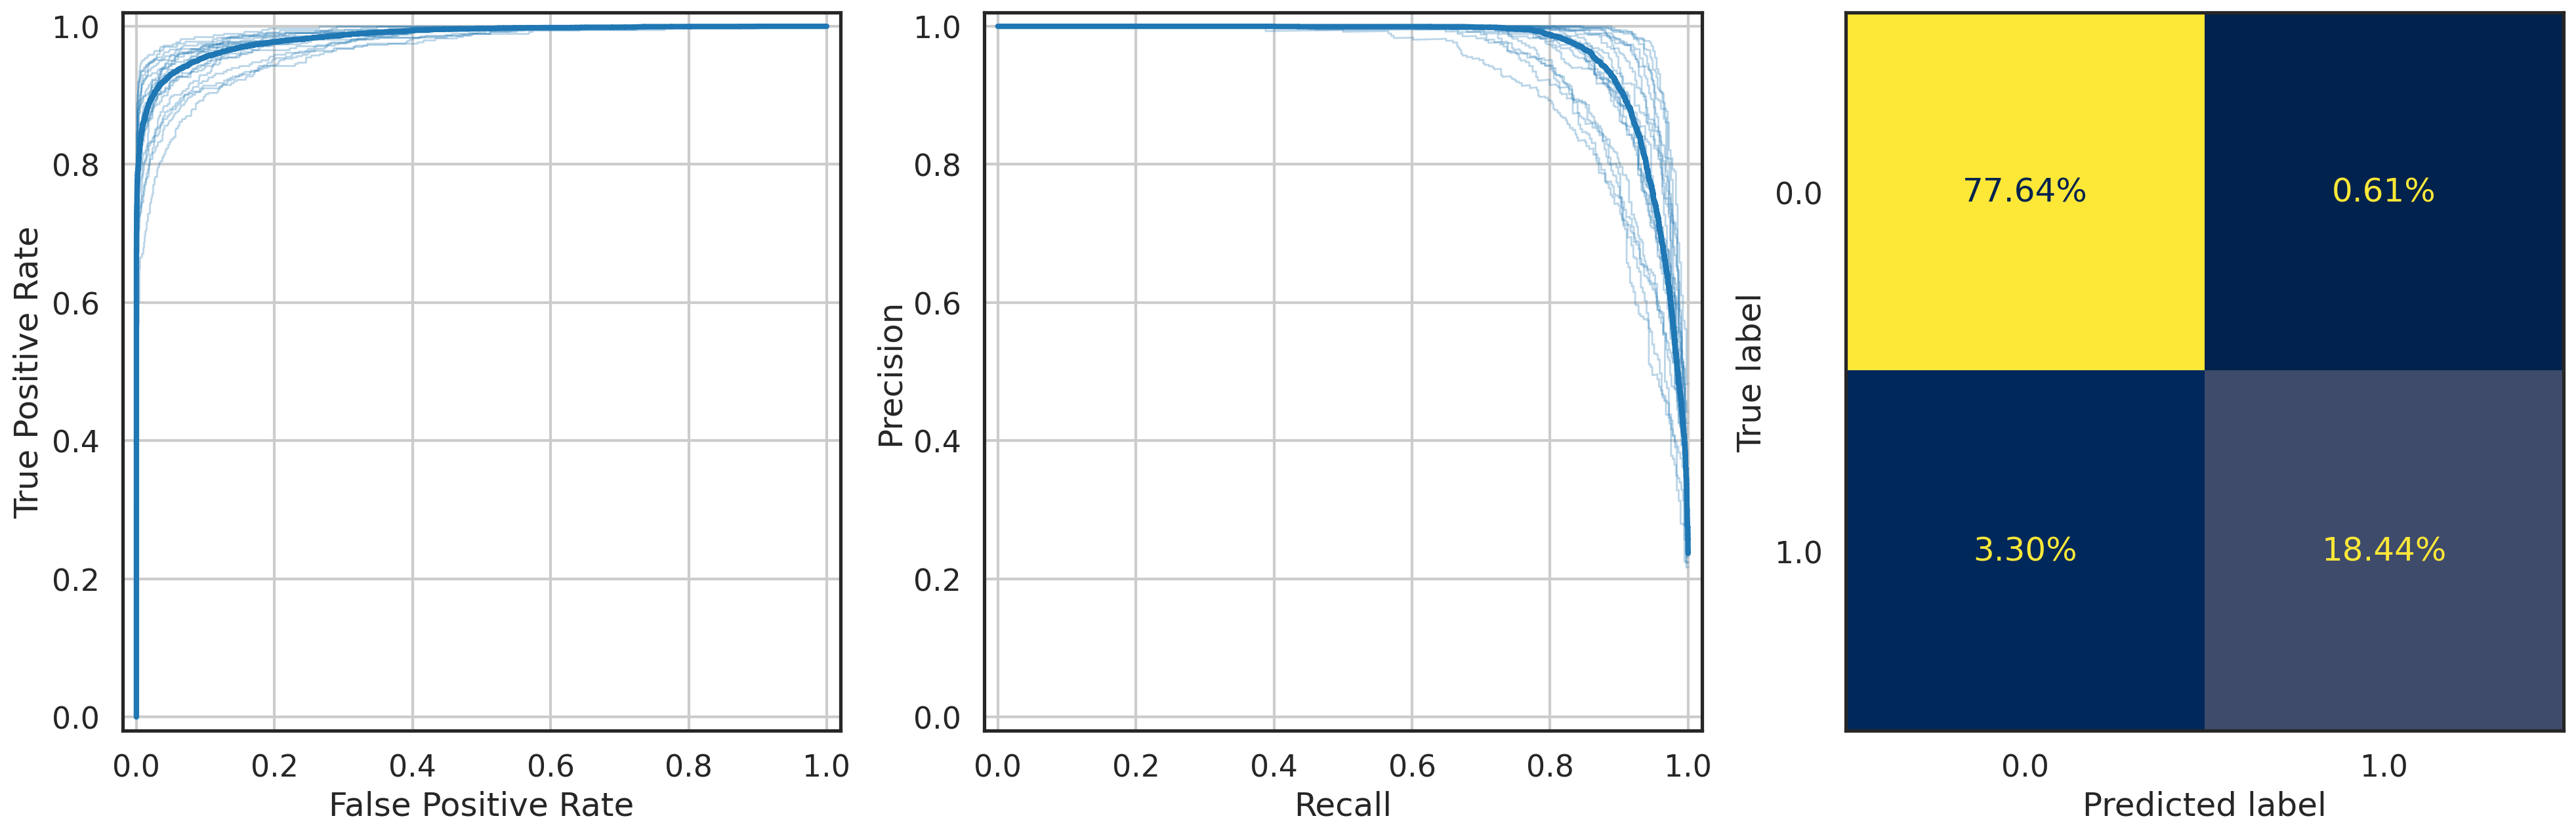

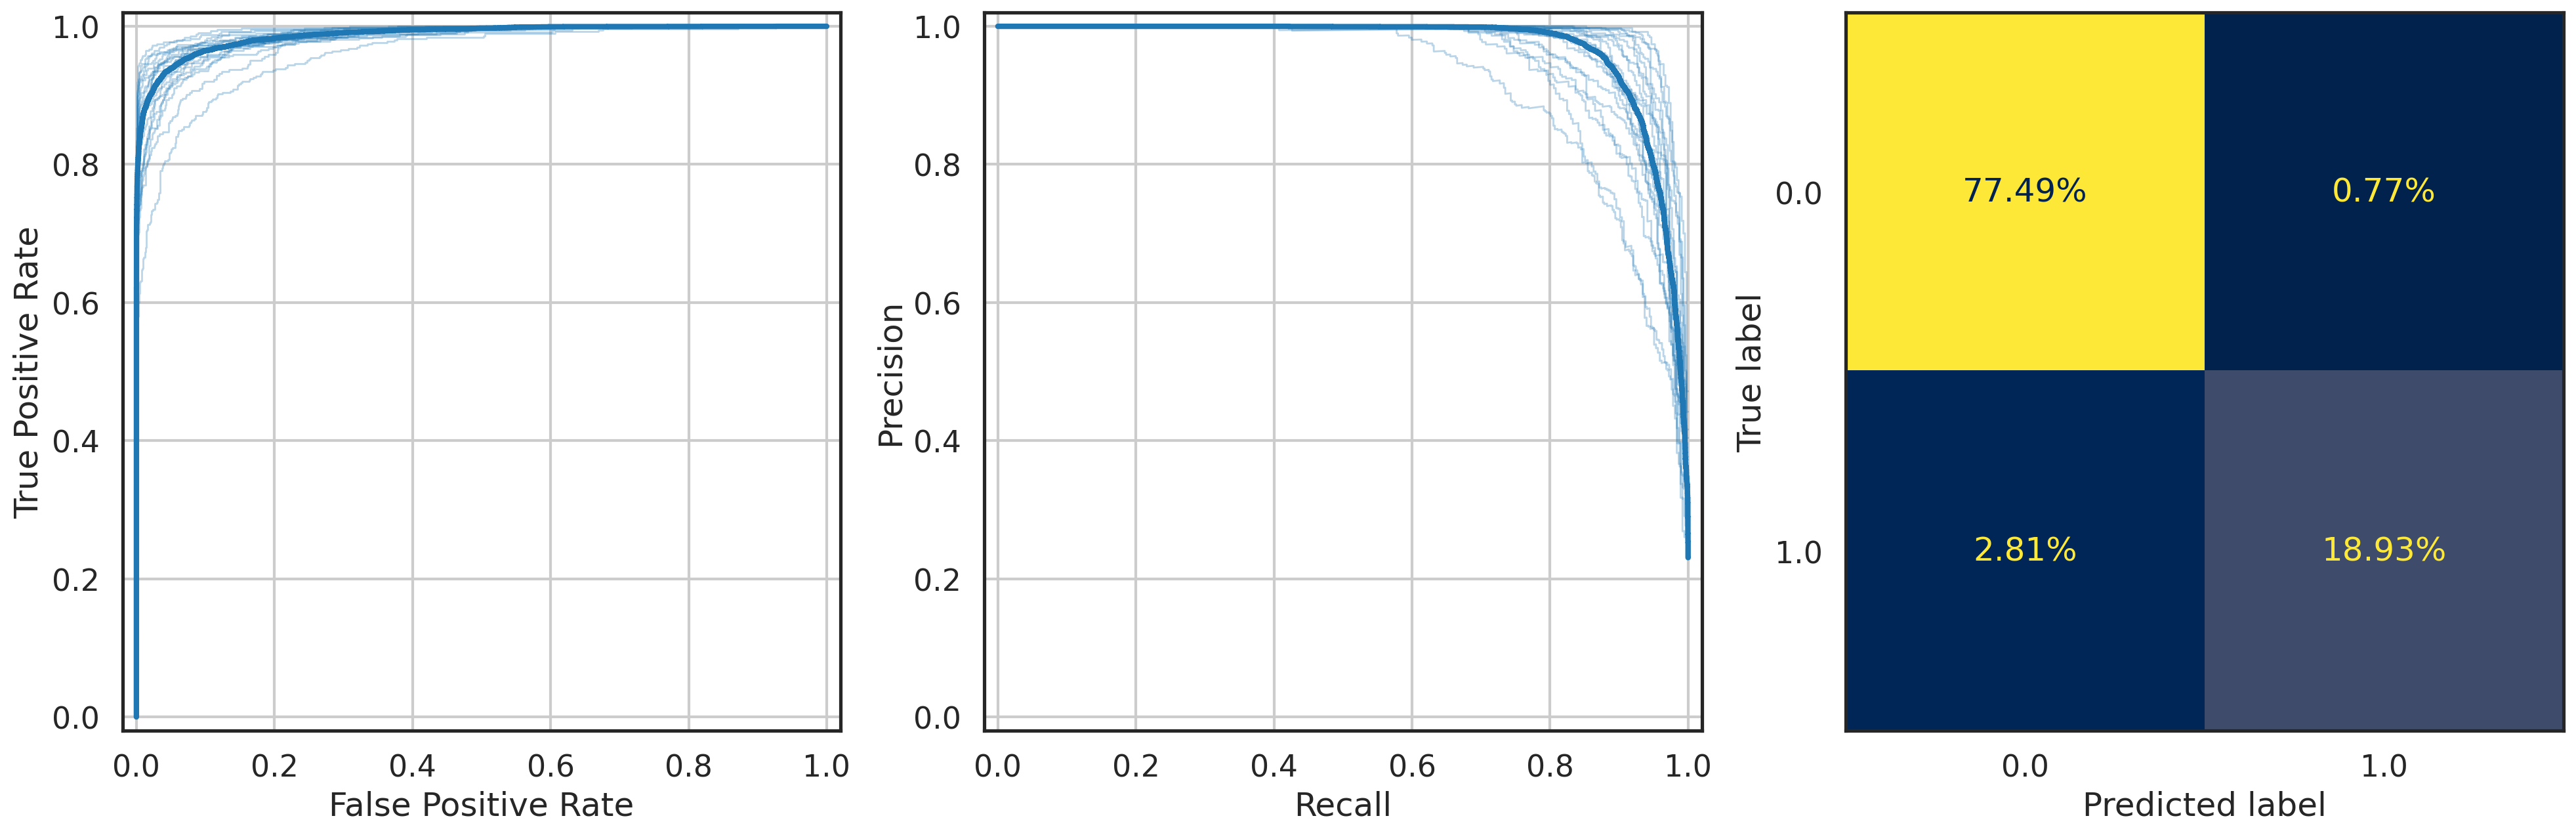

In [7]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(reasoner_original.state_dict(), base+'/reasonerO.pt')
T.save(reasoner_mod.state_dict(), base+'/reasonerM.pt')

df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_orig=Y_te_orig, Y_te_mod=Y_te_mod))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print('original')
print(report(test_onto, y_te, np.array(Y_te_orig), idx_te, save=base+'/%-trained'))
print('modified')
print(report(test_onto, y_te, np.array(Y_te_mod), idx_te, save=base+'/%-random'))

In [8]:
from src.id import print_identity_results
print(print_identity_results(reasoner_original,trained_test_encoders['original reasoner'], seed))

Double Negation:
  Mean Loss: 0.269947
  Std Dev Loss: 0.031853
  Mean Diff: 0.543391
  Std Dev Diff: 0.091171

Duality of Top and Bottom:
  Mean Loss: 0.380861
  Std Dev Loss: 0.000000
  Mean Diff: 0.725492
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.127683
  Std Dev Loss: 0.033625
  Mean Diff: 0.316244
  Std Dev Diff: 0.091712

Associativity:
  Mean Loss: 0.033782
  Std Dev Loss: 0.011368
  Mean Diff: 0.077900
  Std Dev Diff: 0.025813

Commutativity:
  Mean Loss: 0.036402
  Std Dev Loss: 0.012441
  Mean Diff: 0.085667
  Std Dev Diff: 0.031408

Contradiction:
  Mean Loss: 0.375679
  Std Dev Loss: 0.021554
  Mean Diff: 0.804315
  Std Dev Diff: 0.062744

Identity with Top:
  Mean Loss: 0.163003
  Std Dev Loss: 0.040111
  Mean Diff: 0.378183
  Std Dev Diff: 0.106003

Absorption by Bottom:
  Mean Loss: 0.370575
  Std Dev Loss: 0.018244
  Mean Diff: 0.753064
  Std Dev Diff: 0.046374

Top Concept Subsumption:
  Mean Loss: 0.000695
  Std Dev Loss: 0.000865
  Mean Diff: N/A
  Std De

In [9]:
print(print_identity_results(reasoner_mod,trained_test_encoders['modified reasoner'], seed))

Double Negation:
  Mean Loss: 0.000020
  Std Dev Loss: 0.000008
  Mean Diff: 0.000057
  Std Dev Diff: 0.000031

Duality of Top and Bottom:
  Mean Loss: 0.000812
  Std Dev Loss: 0.000000
  Mean Diff: 0.001541
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.109766
  Std Dev Loss: 0.028233
  Mean Diff: 0.258041
  Std Dev Diff: 0.073649

Associativity:
  Mean Loss: 0.021077
  Std Dev Loss: 0.007122
  Mean Diff: 0.047439
  Std Dev Diff: 0.015977

Commutativity:
  Mean Loss: 0.024905
  Std Dev Loss: 0.008888
  Mean Diff: 0.057987
  Std Dev Diff: 0.020843

Contradiction:
  Mean Loss: 0.143192
  Std Dev Loss: 0.039438
  Mean Diff: 0.228788
  Std Dev Diff: 0.046752

Identity with Top:
  Mean Loss: 0.066736
  Std Dev Loss: 0.018752
  Mean Diff: 0.157165
  Std Dev Diff: 0.049161

Absorption by Bottom:
  Mean Loss: 0.019037
  Std Dev Loss: 0.009912
  Mean Diff: 0.043276
  Std Dev Diff: 0.018128

Top Concept Subsumption:
  Mean Loss: 0.001113
  Std Dev Loss: 0.001232
  Mean Diff: N/A
  Std De